# Animated pyplot figure for jupyter notebooks

In [1]:
import writefile_run
filename = '../package/pytorch_utils/nb_figure.py'

In [2]:
%%writefile_run $filename

"""Module which extends matplotlib figures to notebooks. 
Figures are displayed as loaded images using IPython display."""

import matplotlib.pyplot as plt
from IPython.display import *
import numpy as np

In [3]:
%%writefile_run $filename -a


class NBFigure():
    """An extension of matplotlib figure to work with jupyter notebook's display module.
    Works by storing the figure as an image on disk and loading it to display on updating.
    """
    def __init__(self,image_path=None,nrows=1,ncols=1,decorate_fn=None,**subplot_kwargs):
        """
        image_path: the filename of the stored figure image
        decorate_fn: A function which takes in a 2d array of axes, and should perform
            basic plot decorations like labeling, title etc. It is called once.
            
        subplot_kwargs are passed to subplots' kwargs
        """
        
        self.nrows=nrows
        self.ncols=ncols
        self.fig, self.axes = plt.subplots(nrows,ncols,**subplot_kwargs)
        
        self.axes=np.array([self.axes]).reshape(nrows,ncols)
        
        if decorate_fn != None:
            decorate_fn(self.axes)
        
        plt.close(self.fig)
        
        
        self.image_path = image_path
        
        if self.image_path != None:
            self.fig.savefig(image_path, bbox_inches='tight')
            
        self.disp = None
        
        self.xlims = [[(None,None) for j in range(ncols)] for i in range(nrows)]
        self.ylims = [[(None,None) for j in range(ncols)] for i in range(nrows)]
     
    def set_image_path(self, image_path):
        """Sets the path for saving the figure image. This path must be set(either in init 
        or using this function) before display can be called."""
        
        self.image_path = image_path        
        self.fig.savefig(image_path, bbox_inches='tight')
    
    def update_lims(self):
        """
        Updates lims of all axes
        """
        for i in range(self.nrows):
            for j in range(self.ncols):
                ax = self.axes[i][j]
                ax.relim()
#                 ax.autoscale_view()
                ax.autoscale()
                ax.set_xlim(self.xlims[i][j])
                ax.set_ylim(self.ylims[i][j])
                
    def set_xlim(self,xlim,axis_num=0):
        """Set the xlims of the axes indexed row major wise starting from 0.
        Effect will be visible only after update. 
        Setting either limit to None will make that limit update automatically."""
        row = axis_num//self.ncols
        col = axis_num%self.ncols
        self.xlims[row][col]=xlim

    def set_ylim(self,ylim,axis_num=0):
        """Set the ylims of the axes indexed row major wise, starting from 0.
        Effect will be visible only after update.
        Setting either limit to None will make that limit update automatically."""
        row = axis_num//self.ncols
        col = axis_num%self.ncols
        self.ylims[row][col]=ylim
        
    def display(self):
        """Create a display of the figure"""
        self.disp = display(Image(self.image_path),display_id=str(id(self)))
    
    def update(self, update_lims=True):
        """Update the lims(if set to True) and update all display instances"""
        if update_lims:
            self.update_lims()
        self.fig.savefig(self.image_path, bbox_inches='tight')
        self.disp.update(Image(self.image_path))
    
    def getAxis(self,axis_num=0):
        """Get the axis in the subplot indexed row major wise starting from 0."""
        row = axis_num//self.ncols
        col = axis_num%self.ncols
        return self.axes[row][col]

# Testing

## Plotting lines

Demonstrate the phenomenon of aliasing using an animated plot with changing frequency of a sinusoid.

In [4]:
plt.style.use('dark_background')
plt.rcParams['axes.grid']=True
plt.rcParams['font.size']=15

In [5]:
def decorate(axes):
    axes[0][0].set_title("Time domain")
    axes[0][0].set_ylabel("$y$")
    axes[0][0].set_xlabel("$t$")
    
    axes[0][1].set_title("Discrete Fourier Transform")
    axes[0][1].set_xlabel("$\omega$ in radians")
    axes[0][1].set_ylabel("Magnitude")

### Setup for plotting DFTs

In [6]:
t_range = (-np.pi,np.pi)
n_samples = 100
sampling_freq = 2*np.pi*n_samples/(t_range[1]-t_range[0])
w_range = (-sampling_freq/2,sampling_freq/2)

t = np.linspace(*t_range,n_samples+1)[:-1]
w = np.linspace(*w_range,n_samples+1)[:-1]

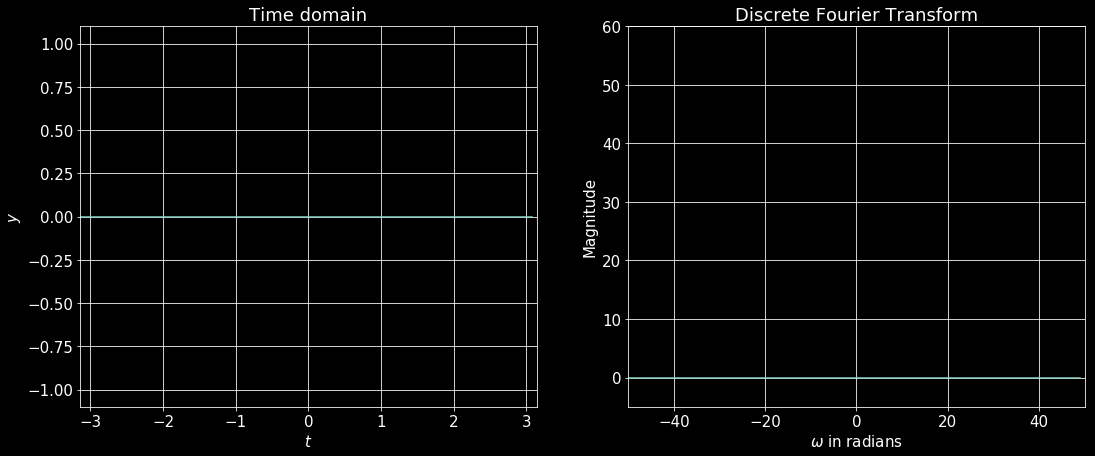

Frequency = 100 rad/s

In [7]:
nbfig = NBFigure('fourier.png',figsize=(18,7),ncols=2,decorate_fn=decorate)
nbfig.set_xlim(t_range)
nbfig.set_xlim(w_range,1)
nbfig.set_ylim((-1.1,1.1))
nbfig.set_ylim((-5,60),1)
sig, = nbfig.getAxis(0).plot([0],[0])
dft, = nbfig.getAxis(1).plot([0],[0])
nbfig.display()
nbfig.update()
d = display(Markdown(''),display_id='freq_text')

### Update loop

In [8]:
for freq in range(101):
    y = np.sin(freq*t)
    sig.set_data(t,y)
    d.update(Markdown('Frequency = {} rad/s'.format(freq)))
    df = np.fft.fftshift(np.fft.fft(y))
    dft.set_data(w,abs(df))
    nbfig.update(update_lims=False)

# Plotting images

In [9]:
def decorate2(axes):
    axes[0][0].axis('off')
    axes[0][0].set_title('Animated image')

In [10]:
nbfig = NBFigure('sine.png',figsize=(6,6),decorate_fn=decorate2)
ax = nbfig.getAxis()

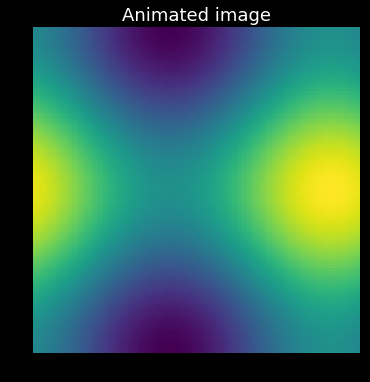

In [11]:
def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2*np.pi, 100)
y = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)

im = ax.imshow(f(x,y))
nbfig.display()
nbfig.update()

### Update loop

In [12]:
for i in range(100):
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    nbfig.update()